# ENHANCING USER AUTHENTICATION EXPERIENCE THROUGH BIG DATA ANALYSIS AND SINGLE SIGN-ON INTEGRATION
## K-MEANS ALGORITHM

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score


In [3]:
data = pd.read_csv('../rba-dataset/rba-dataset.csv', nrows=2000, index_col='index')

In [4]:
data.dropna(inplace=True)

In [5]:
# Preprocessing
data['Login Timestamp'] = pd.to_datetime(data['Login Timestamp'])
data['hour'] = data['Login Timestamp'].dt.hour
data['day_of_week'] = data['Login Timestamp'].dt.dayofweek
data['is_weekend'] = data['Login Timestamp'].dt.weekday >= 5

# New feature: Number of unique IP addresses per user
data['unique_ips'] = data.groupby('User ID')['IP Address'].transform('nunique')

features = [
    'User ID', 'Round-Trip Time [ms]', 'unique_ips', 'Country', 'Region', 
    'City', 'ASN', 'User Agent String', 'Browser Name and Version', 
    'OS Name and Version', 'Device Type', 'Is Attack IP', 'Is Account Takeover',
    'hour', 'day_of_week', 'is_weekend'
]
target = 'Login Successful'

X = data[features]
y = data[target]

categorical_features = ['Country', 'Region', 'City', 'User Agent String',
                        'Browser Name and Version', 'OS Name and Version', 'Device Type']
numerical_features = ['User ID', 'Round-Trip Time [ms]', 'ASN', 'hour', 'day_of_week', 'is_weekend', 'unique_ips']

# Preprocessing pipelines for both numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTETomek to the preprocessed training data
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train_preprocessed, y_train)

# Define base models for stacking
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
)

# Hyperparameter tuning for the stacking classifier
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(stacking_clf, param_distributions=param_grid, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = random_search.predict(X_test_preprocessed)
print('Best Parameters:', random_search.best_params_)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test, random_search.predict_proba(X_test_preprocessed)[:, 1]))

Best Parameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 200, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 1.0}
Accuracy: 0.7058823529411765
Classification Report:               precision    recall  f1-score   support

       False       0.50      0.40      0.44         5
        True       0.77      0.83      0.80        12

    accuracy                           0.71        17
   macro avg       0.63      0.62      0.62        17
weighted avg       0.69      0.71      0.70        17

ROC-AUC Score: 0.65


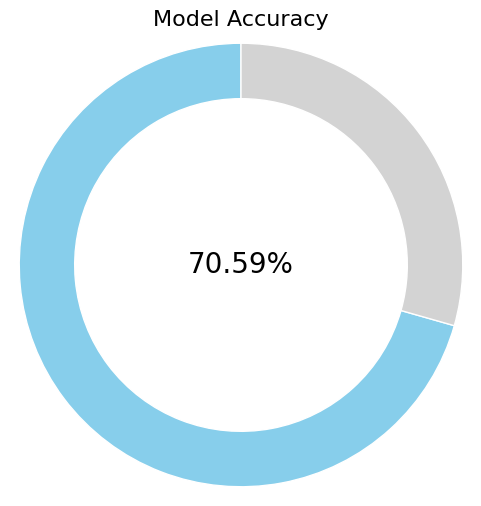

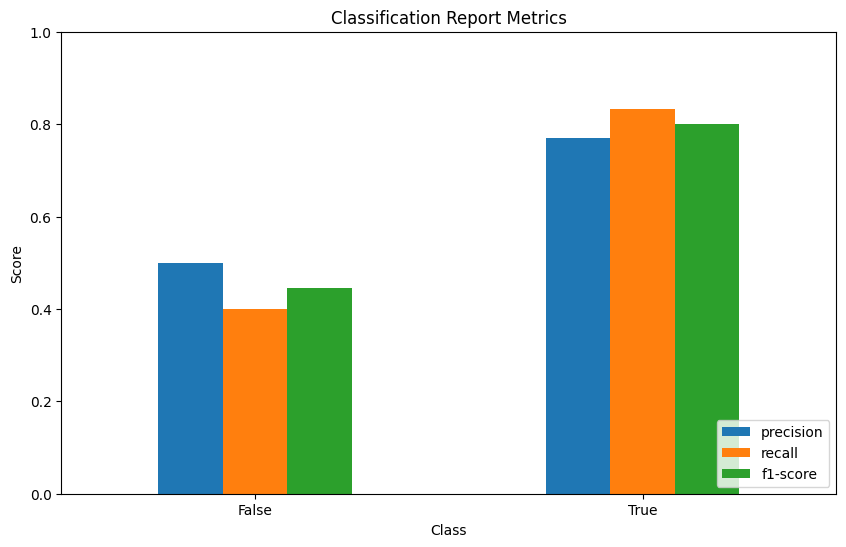

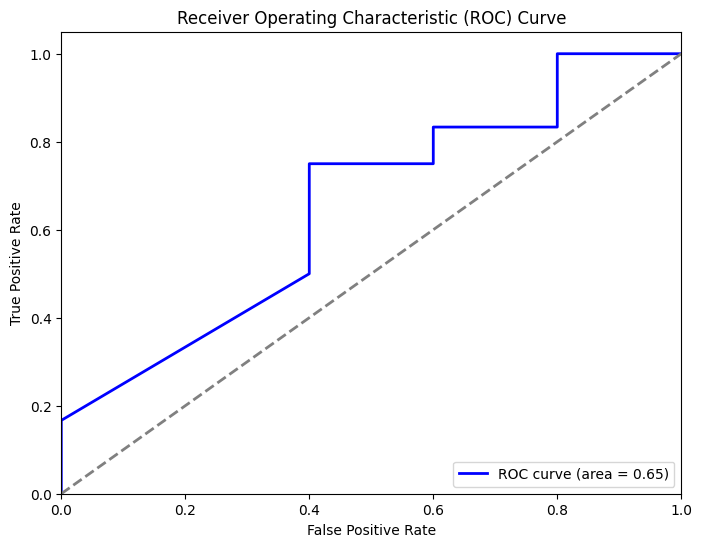

In [9]:
# Accuracy Bar Chart
accuracy = accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

# Create a pie chart with a hole in the middle (donut chart)
wedges, texts = ax.pie([accuracy, 1-accuracy], 
                       radius=1.2, 
                       colors=['skyblue', 'lightgray'], 
                       startangle=90, 
                       wedgeprops=dict(width=0.3, edgecolor='w'))

# Add a center circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Model Accuracy', fontsize=16)

# Add text in the middle
plt.text(0, 0, f'{accuracy:.2%}', horizontalalignment='center', verticalalignment='center', fontsize=20)

plt.show()

# Classification Report Metrics
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

# Plot grouped bar chart
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# ROC Curve
y_pred_proba = random_search.predict_proba(X_test_preprocessed)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
